In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import pickle
import gzip
from scipy.stats import circmean, circvar



def CircleDist(a, b):
    dx = abs(a - b)
    dx = np.minimum(dx, 2 * np.pi - dx)
    return dx

def ToroidalDist(angles, D): #CHANGED
        D = np.array(D)
        theta = angles[0]
        phi = angles[1]
        #print("tehta, phi, D: ", theta, phi, D)
        
        dx = abs(D[:, 0] - theta)
        dy = abs(D[:, 1] - phi)
        dx = np.minimum(dx, 2 * np.pi - dx)
        dy = np.minimum(dy, 2 * np.pi - dy)
        #print(dx,dy)
        distances = np.sqrt(dx**2 + dy**2)
        return distances


def meanandstd_circles(points):
    mean_theta = circmean(points[:,0])
    mean_phi = circmean(points[:,1])
    var_theta = circvar(points[:,0])
    var_phi = circvar(points[:,1])
    std_theta = np.sqrt(var_theta)
    std_phi = np.sqrt(var_phi)
    mean_result = np.array([mean_theta, mean_phi])
    std_result = np.array([std_theta, std_phi])

    std_result = (std_theta + std_phi) / 2
    return mean_result, std_result

def meanandstd2(points):
    cpoints = np.zeros(2)
    cpoints[0] = np.arctan2(np.sum(np.sin(points[:,0])), np.sum(np.cos(points[:,0])))
    cpoints[1] = np.arctan2(np.sum(np.sin(points[:,1])), np.sum(np.cos(points[:,1])))
    def mindist(a):
        return(np.mean(ToroidalDist(a, points)))
        
    res = minimize(mindist, cpoints+0.01, method='L-BFGS-B')
    response = (res.x, np.sqrt(res.fun))
    return response

#return(np.mean(CircleDist(a[0], points[0]))+ np.mean(CircleDist(a[1], points[1])))
np.random.seed(42)  # For reproducibility
num_points = 100
angles = np.random.uniform(0, 2 * np.pi, (num_points, 2))
valuesCirc1 = meanandstd_circles(angles)
valuesCirc2 = meanandstd2(angles)

print(valuesCirc2[0])
print(valuesCirc1[0])
# diff = valuesCirc + valuesTor
# print(diff)

[0.37903341 1.20581971]
[0.35249142 1.40226182]


In [15]:
#NOT DISTINCT CIRCLES AND NO GAUSSIAN WALK

def makehddata(N):
    h = 0.1
    beta0 = 20
    beta_and_h = np.sqrt( beta0/h) # Here i make the peak-response closer to the value for the torus
    sigma = np.pi/4
    hd_sim = np.random.uniform(0, 2 * np.pi, size=(2, T))
    rf_hd = np.random.uniform(0, 2 * np.pi, size=(2, N))
    S = np.zeros((N, T))

    max_response = float('-inf')
    max_exp_response = float('-inf')
    max_dist1 = float('-inf')
    max_dist2 = float('-inf')
    for i in range(N):
        for t in range(T):
            dist1 = CircleDist(rf_hd[0, i], hd_sim[0, t])
            dist2 = CircleDist(rf_hd[1, i], hd_sim[1, t])
            response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist1**2 / (2 * sigma**2)) + (np.log(beta_and_h)) * np.exp(-dist2**2 / (2 * sigma**2))
 
            max_dist1 = max(max_dist1, dist1)
            max_dist2 = max(max_dist2, dist2)
            max_response = max(max_response, response)
            max_exp_response = max(max_exp_response, np.exp(response))

            S[i, t] = np.random.poisson(lam=np.exp(response))

    return (hd_sim, S, rf_hd, max_response, max_exp_response, max_dist1, max_dist2)

N = 100
T = 3000
hd_sim1, S_11, rf_hd_array1, max_response, max_exp_response , max_dist1, max_dist2= makehddata(N)



print(max_response, max_exp_response , max_dist1, max_dist2)


# hd_sim_train, hd_sim_test, S_train, S_test = train_test_split(hd_sim1.T, S_11.T, test_size=0.2, random_state=42)
# hd_sim_train, hd_sim_test, S_train, S_test = hd_sim_train.T, hd_sim_test.T, S_train.T, S_test.T
# S_train, S_test = S_train.T, S_test.T
#print(hd_sim1.shape, S1.shape)
#data = {'hd_train':hd_sim1,'hd_test': hd_sim_test,  'S_train':S_11, 'S_test':S_test} # Use all the data for training

split_index = int(T * 0.8)
hd_sim_train = hd_sim1[:, :split_index]
hd_sim_test = hd_sim1[:, split_index:]
S_train = S_11[:, :split_index]
S_test = S_11[:, split_index:]

data = {'hd_train':hd_sim_train,'hd_test':hd_sim_test,'S_train':S_train, 'S_test':S_test} # Use all the data for training
with gzip.open('twocirclesadditive.pkl.gz', 'wb') as f:
  pickle.dump(data, f)


print("Dimensions of hd_sim, train and test: ", hd_sim_train.shape, hd_sim_test.shape)

print("Dimensions of S, train and test: ", S_train.shape, S_test.shape)

print("Mean of S: ", np.mean(S_11))




2.9956639147506188 19.99863287066075 3.141590846619895 3.141574660348012
Dimensions of hd_sim, train and test:  (2, 2400) (2, 600)
Dimensions of S, train and test:  (100, 2400) (100, 600)
Mean of S:  1.38906


In [14]:
#DISTINCT CIRCLES AND NO GAUSSIAN WALK

def makehddata(N):
    h = 0.1
    beta0 = 20
    beta_and_h = ( beta0/h) # Here i make the peak-response closer to the value for the torus
    sigma = np.pi/4
    hd_sim = np.random.uniform(0, 2 * np.pi, size=(2, T))
    rf_hd = np.random.uniform(0, 2 * np.pi, size=(2, N))
    S = np.zeros((N, T))

    max_response = float('-inf')
    max_exp_response = float('-inf')
    max_dist1 = float('-inf')
    max_dist2 = float('-inf')
    allocation = np.zeros(N)
    for i in range(N):
        for t in range(T):
            dist1 = CircleDist(rf_hd[0, i], hd_sim[0, t])
            dist2 = CircleDist(rf_hd[1, i], hd_sim[1, t])
            #response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist1**2 / (2 * sigma**2)) + (np.log(beta_and_h)) * np.exp(-dist2**2 / (2 * sigma**2))
            if i<N/2:
              response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist1**2 / (2 * sigma**2))
              allocation[i]=0
            else:
              response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist2**2 / (2 * sigma**2))
              allocation[i]=1
            max_dist1 = max(max_dist1, dist1)
            max_dist2 = max(max_dist2, dist2)
            max_response = max(max_response, response)
            max_exp_response = max(max_exp_response, np.exp(response))

            S[i, t] = np.random.poisson(lam=np.exp(response))

    return (hd_sim, S, rf_hd, max_response, max_exp_response, max_dist1, max_dist2, allocation)

N = 50
T = 3000
hd_sim1, S_11, rf_hd_array1, max_response, max_exp_response , max_dist1, max_dist2, allocation= makehddata(N)



print(max_response, max_exp_response , max_dist1, max_dist2)


# hd_sim_train, hd_sim_test, S_train, S_test = train_test_split(hd_sim1.T, S_11.T, test_size=0.2, random_state=42)
# hd_sim_train, hd_sim_test, S_train, S_test = hd_sim_train.T, hd_sim_test.T, S_train.T, S_test.T
# S_train, S_test = S_train.T, S_test.T
#print(hd_sim1.shape, S1.shape)
#data = {'hd_train':hd_sim1,'hd_test': hd_sim_test,  'S_train':S_11, 'S_test':S_test} # Use all the data for training
split_index = int(T * 0.8)
hd_sim_train = hd_sim1[:, :split_index]
hd_sim_test = hd_sim1[:, split_index:]
S_train = S_11[:, :split_index]
S_test = S_11[:, split_index:]

data = {'hd_train':hd_sim_train,'hd_test':hd_sim_test,'S_train':S_train, 'S_test':S_test, 'allocation':allocation} # Use all the data for training
with gzip.open('twocirclesseparable.pkl.gz', 'wb') as f:
  pickle.dump(data, f)


print("Dimensions of hd_sim, train and test: ", hd_sim_train.shape, hd_sim_test.shape)

print("Dimensions of S, train and test: ", S_train.shape, S_test.shape)

print("Mean of S: ", np.mean(S_11))



2.9957322734761678 19.999999998443535 3.141570040112544 3.1415847292274437
Dimensions of hd_sim, train and test:  (2, 2400) (2, 600)
Dimensions of S, train and test:  (100, 2400) (100, 600)
Mean of S:  3.047006666666667


In [5]:
print(S_11[:,1])

[ 0.  0.  1.  0.  0.  0.  0.  1.  0.  0. 10.  0.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  6.
  0.  0.  0.  1.  1.  0.  0. 14.  0.  1.  4.  1.  0.  1.  0.  0.  0.  2.
  1.  0.  1.  0.  1.  2.  3.  0.  0.  1.  0.  0.  0.  2.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  1. 22.  0.  3.  1.  0.  0.  0.  0.
  3.  0.  0.  4.  1.  0.  6.  0.  1.  2.]


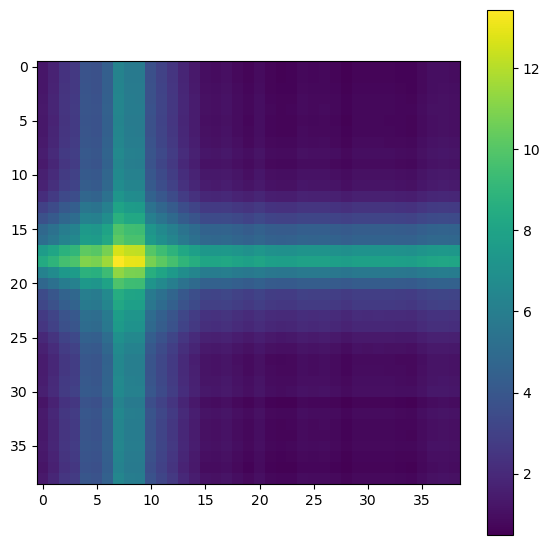

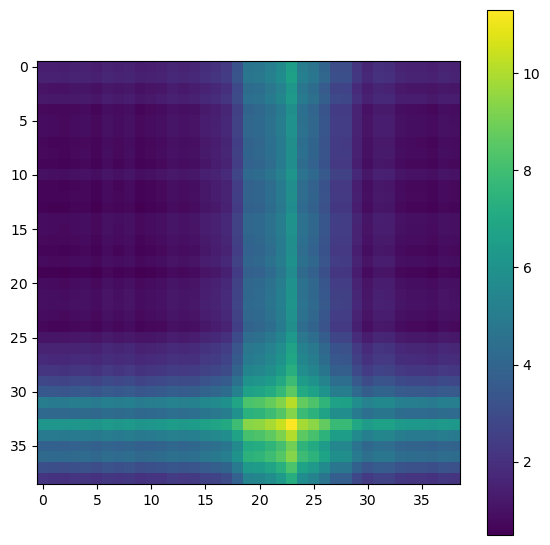

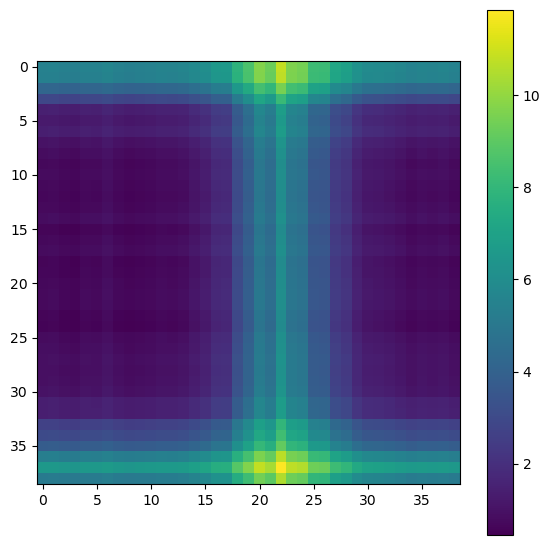

In [6]:
nr_bins = 40
angles = np.linspace(0, 2*np.pi+0.00001, nr_bins)
angleverts = (0.5*(angles[0:(-1)]+angles[1:]))
angleverts2d = np.zeros((nr_bins-1,nr_bins-1))
#plt.hist2d(hd_sim[0], hd_sim[1],bins=(30,30))
#plt.show()
for i in range(1):
  tuningcurve = np.zeros(len(angleverts))
  tuningcurve2 = np.zeros(len(angleverts))
  for j in range(len(angleverts)):
    inds0 = (hd_sim1[0]>=angles[j]) * (hd_sim1[0]<angles[j+1])

    tuningcurve[j] = np.mean(S_11[i,inds0])
    inds1 = (hd_sim1[1]>=angles[j]) * (hd_sim1[1]<angles[j+1])
    tuningcurve2[j] = np.mean(S_11[i,inds1])

    for k in range(len(angleverts)):
       inds2 = (hd_sim1[1]>=angles[k]) * (hd_sim1[1]<angles[k+1]) 
      #  ind2d = indsO0*inds2
      #  angleverts1d1 = np.mean(S1[i, indsO0])
      #  angleverts1d2 = np.mean(S1[i, inds2])
       angleverts2d[j,k] = np.mean(S_11[i, inds0]) + np.mean(S_11[i, inds2])
       #print(angleverts2d[j,k])
  plt.figure(figsize=(15,15))  
  fr = plt.subplot(2,2,i+1)

  plt.imshow(angleverts2d)
  plt.colorbar()
  # plt.show()

  # plt.figure(figsize=(15,15))
  # plt.imshow(angleverts1d1)
  # plt.colorbar()
  # plt.show()

  # plt.figure(figsize=(15,15))
  # plt.imshow(angleverts1d2)
  # plt.colorbar()


  
plt.show()

for i in range(N-51, N-49):
  tuningcurve = np.zeros(len(angleverts))
  tuningcurve2 = np.zeros(len(angleverts))
  for j in range(len(angleverts)):
    inds0 = (hd_sim1[0]>=angles[j]) * (hd_sim1[0]<angles[j+1])

    tuningcurve[j] = np.mean(S_11[i,inds0])
    inds1 = (hd_sim1[1]>=angles[j]) * (hd_sim1[1]<angles[j+1])
    tuningcurve2[j] = np.mean(S_11[i,inds1])

    for k in range(len(angleverts)):
       inds2 = (hd_sim1[1]>=angles[k]) * (hd_sim1[1]<angles[k+1]) 
      #  ind2d = indsO0*inds2
      #  angleverts1d1 = np.mean(S1[i, indsO0])
      #  angleverts1d2 = np.mean(S1[i, inds2])
       angleverts2d[j,k] = np.mean(S_11[i, inds0]) + np.mean(S_11[i, inds2])
       #print(angleverts2d[j,k])
  plt.figure(figsize=(15,15))  
  fr = plt.subplot(2,2,N-49-(i))

  plt.imshow(angleverts2d)
  plt.colorbar()
  plt.show()

In [1]:
#ALTERNATIVE WITH GAUSSIAN WALK

import numpy as np



def CircleDist(a, b):
    dx = abs(a - b)
    dx = np.minimum(dx, 2 * np.pi - dx)
    return dx

def gaussian_walk_on_circle(start, T, sigma):
    walk = np.zeros(T)
    walk[0] = start
    for i in range(1, T):
        increment = np.random.normal(0, sigma)  # Generate a Gaussian increment
        walk[i] = (walk[i - 1] + increment) % (2 * np.pi)  # Wrap around the circle
    return walk

def makehddata(N):
    h = 0.1
    beta0 = 20
    beta_and_h = np.sqrt(beta0 / h)
    sigma = np.pi / 2
    # Starting point for Gaussian walks
    start1 = np.random.uniform(0, 2 * np.pi)
    start2 = np.random.uniform(0, 2 * np.pi)
    # Generate Gaussian walks
    hd_sim = np.array([gaussian_walk_on_circle(start1, T, sigma/10),
                       gaussian_walk_on_circle(start2, T, sigma/10)])
    rf_hd = np.random.uniform(0, 2 * np.pi, size=(2, N))
    S = np.zeros((N, T))

    max_response = float('-inf')
    max_exp_response = float('-inf')
    max_dist1 = float('-inf')
    max_dist2 = float('-inf')
    for i in range(N):
        for t in range(T):
            dist1 = CircleDist(rf_hd[0, i], hd_sim[0, t])
            dist2 = CircleDist(rf_hd[1, i], hd_sim[1, t])

            response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist1**2 / (2 * sigma**2)) + (np.log(beta_and_h)) * np.exp(-dist2**2 / (2 * sigma**2))
            max_dist1 = max(max_dist1, dist1)
            max_dist2 = max(max_dist2, dist2)
            max_response = max(max_response, response)
            max_exp_response = max(max_exp_response, np.exp(response))

            S[i, t] = np.random.poisson(lam=np.exp(response))

    return (hd_sim, S, rf_hd, max_response, max_exp_response, max_dist1, max_dist2)

T=2000
N = 100
hd_sim1, S_1, rf_hd_array1, max_response, max_exp_response , max_dist1, max_dist2= makehddata(N)



print(max_response, max_exp_response , max_dist1, max_dist2)


hd_sim_train, hd_sim_test, S_train, S_test = train_test_split(hd_sim1.T, S_1.T, test_size=0.2, random_state=42)
# S_train, S_test = S_train.T, S_test.T
#print(hd_sim1.shape, S1.shape)
data = {'hd_train':hd_sim1,'hd_test': hd_sim_test,  'S_train':S_1, 'S_test':S_test} # Use all the data for training
with gzip.open('twocirclesGW.pkl.gz', 'wb') as f:
  pickle.dump(data, f)


print("Dimensions of hd_sim, train and test: ", hd_sim_train.shape, hd_sim_test.shape)

print("Dimensions of S, train and test: ", S_train.shape, S_test.shape)

print("Mean of S: ", np.mean(S_1))

2.995722189198944 19.999798313915996 3.1415785220418906 3.1415899683995443



KeyboardInterrupt



In [16]:
#ALTERNATIVE WITH GAUSSIAN WALK AND DISTINCT CIRCLES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import pickle
import gzip


def CircleDist(a, b):
    dx = abs(a - b)
    dx = np.minimum(dx, 2 * np.pi - dx)
    return dx

def gaussian_walk_on_circle(start, T, sigma):
    walk = np.zeros(T)
    walk[0] = start
    for i in range(1, T):
        increment = np.random.normal(0, sigma)  # Generate a Gaussian increment
        walk[i] = (walk[i - 1] + increment) % (2 * np.pi)  # Wrap around the circle
    return walk

def makehddata(N):
    h = 0.1
    beta0 = 20
    beta_and_h = (beta0 / h)
    sigma = np.pi / 4
    # Starting point for Gaussian walks
    start1 = np.random.uniform(0, 2 * np.pi)
    start2 = np.random.uniform(0, 2 * np.pi)
    hd_sim=np.zeros((2,T))
    hd_sim[:,0]  = (start1,start2)
    # Generate Gaussian walks
    for t in range(1,T):
        hd_sim[0, t] = hd_sim[0, t - 1] + np.random.normal(0, sigma / 10)
        hd_sim[1, t] = hd_sim[1, t - 1] + np.random.normal(0, sigma / 10)
        # Ensure the value stays within the range [0, 2*pi]
        hd_sim[:, t] %= (2 * np.pi)
    rf_hd1 = np.random.uniform(0, 2 * np.pi, size=( int(N)))
    rf_hd2 = np.random.uniform(0, 2 * np.pi, size=( int(N)))


    S = np.zeros((N, T))

    max_response = float('-inf')
    max_exp_response = float('-inf')
    max_dist1 = float('-inf')
    max_dist2 = float('-inf')
    allocation=np.zeros(N)
    for i in range(int(N)):
        for t in range(T):
            dist1 = CircleDist(rf_hd1[ i], hd_sim[0, t])
            dist2 = CircleDist(rf_hd2[ i], hd_sim[1, t])

            if(i<N/2):
               response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist1**2 / (2 * sigma**2))
               allocation[i]=0
            else:
                allocation[i]=1
                response = np.log(h) + (np.log(beta_and_h)) * np.exp(-dist2**2 / (2 * sigma**2))
            max_dist1 = max(max_dist1, dist1)
            max_dist2 = max(max_dist2, dist2)
            max_response = max(max_response, response)
            max_exp_response = max(max_exp_response, np.exp(response))

            S[i, t] = np.random.poisson(lam=np.exp(response))
    rf_hd = (rf_hd1, rf_hd2)
    return (hd_sim, S, rf_hd, max_response, max_exp_response, max_dist1, max_dist2,allocation)




np.random.seed(1001)
N=50
T=3000
hd_sim1, S_1, rf_hd_array1, max_response, max_exp_response , max_dist1, max_dist2, allocation= makehddata(N)



print(max_response, max_exp_response , max_dist1, max_dist2)


split_index = int(T * 0.8)
hd_sim_train = hd_sim1[:, :split_index]
hd_sim_test = hd_sim1[:, split_index:]
S_train = S_1[:, :split_index]
S_test = S_1[:, split_index:]
# S_train, S_test = S_train.T, S_test.T
#print(hd_sim1.shape, S1.shape)
data = {'hd_train':hd_sim1,'hd_test': hd_sim_test,  'S_train':S_1, 'S_test':S_test, "allocation":allocation} # Use all the data for training
with gzip.open('twocirclesseparableGW.pkl.gz', 'wb') as f:
  pickle.dump(data, f)

print("Dimensions of hd_sim and S, presplit: ", hd_sim1.shape, S_1.shape)
print("Dimensions of hd_sim, train and test: ", hd_sim_train.shape, hd_sim_test.shape)

print("Dimensions of S, train and test: ", S_train.shape, S_test.shape)

print("array of which neuron belongs to which ensembel: ", allocation, np.sum(allocation))


print(S_train[1,:])
print(np.mean(hd_sim1[0,:]))
print(np.mean(hd_sim1[1,:]))

2.995732271689827 19.999999962716718 3.1415619254850617 3.1415023548522507
Dimensions of hd_sim and S, presplit:  (2, 3000) (50, 3000)
Dimensions of hd_sim, train and test:  (2, 2400) (2, 600)
Dimensions of S, train and test:  (50, 2400) (50, 600)
array of which neuron belongs to which ensembel:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] 25.0
[13.  6.  5. ...  6.  7.  0.]
3.382255222452192
3.5788408614740717


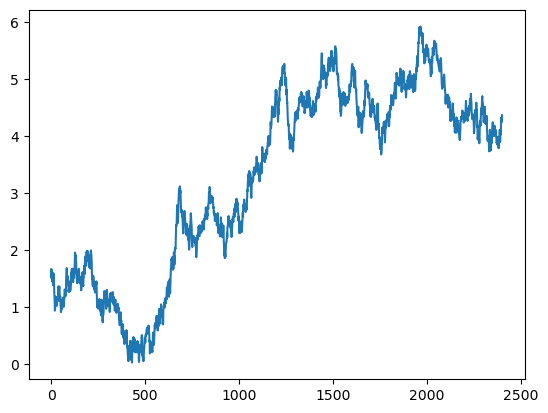

In [11]:
plt.figure()
plt.plot(hd_sim_train[1,:])

# plt.figure()
# plt.plot(S_11[0,:])
# print(np.mean(S_1[0,:]),np.mean(S_11[0,:]) 

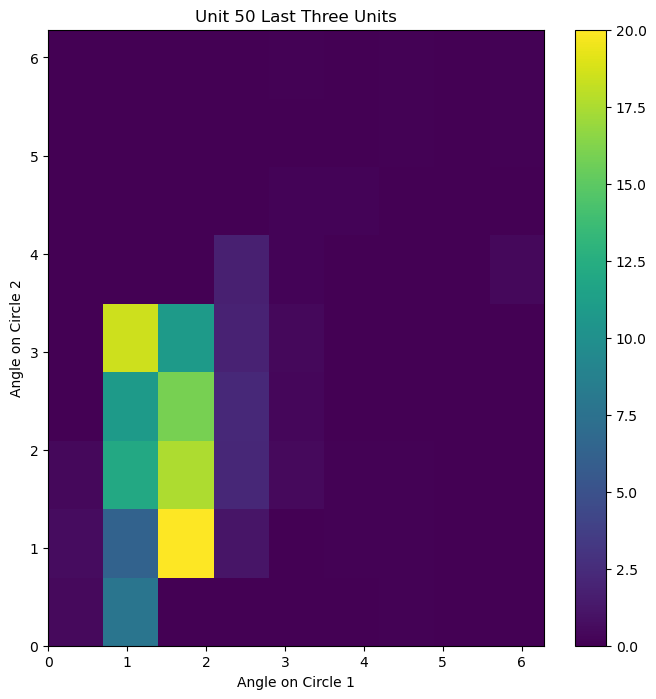

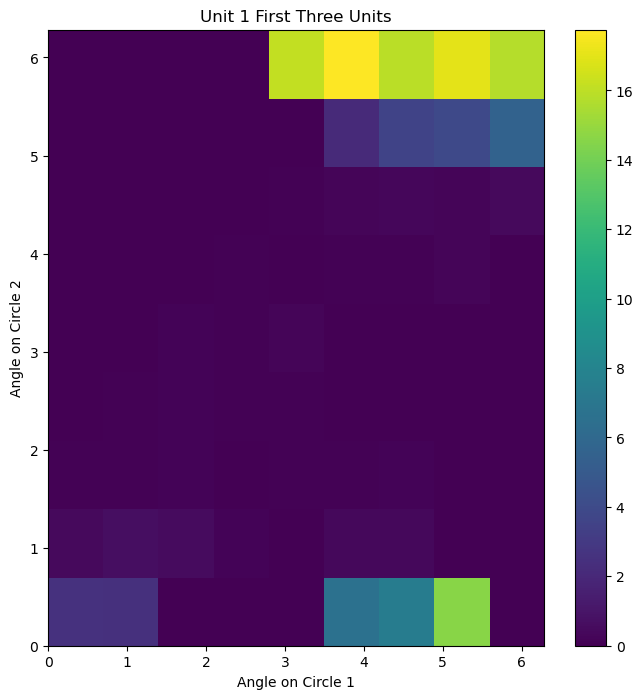

In [15]:
nr_bins = 10
angles = np.linspace(0, 2 * np.pi + 0.00001, nr_bins)
angleverts = (0.5 * (angles[:-1] + angles[1:]))
angleverts2d = np.zeros((nr_bins - 1, nr_bins - 1))

def plot_heatmaps(S, hd_sim, units, title):
    for i in units:
        angleverts2d = np.zeros((nr_bins - 1, nr_bins - 1))
        for j in range(len(angleverts)):
            inds0 = (hd_sim[0] >= angles[j]) & (hd_sim[0] < angles[j + 1])
            for k in range(len(angleverts)):
                inds1 = (hd_sim[1] >= angles[k]) & (hd_sim[1] < angles[k + 1])
                combined_inds = inds0 & inds1
                if np.any(combined_inds):
                    angleverts2d[j, k] = np.mean(S[i, combined_inds])
                else:
                    angleverts2d[j, k] = 0

        plt.figure(figsize=(8, 8))
        plt.title(f'Unit {i+1} {title}')
        plt.imshow(angleverts2d, extent=(0, 2 * np.pi, 0, 2 * np.pi), origin='lower', aspect='auto')
        plt.colorbar()
        plt.xlabel('Angle on Circle 1')
        plt.ylabel('Angle on Circle 2')
        plt.show()

# Plotting the last three units
plot_heatmaps(S_1, hd_sim1, range(N-1,N), 'Last Three Units')

# Plotting the first three units
plot_heatmaps(S_1, hd_sim1, range(1), 'First Three Units')

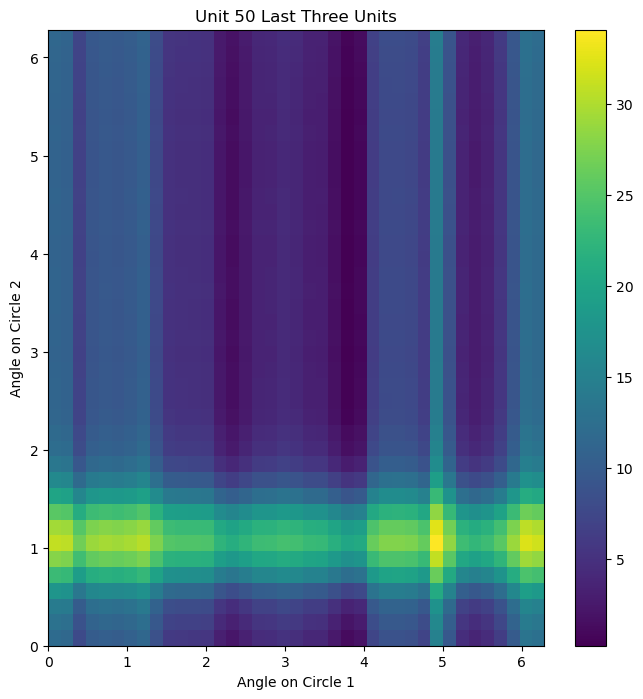

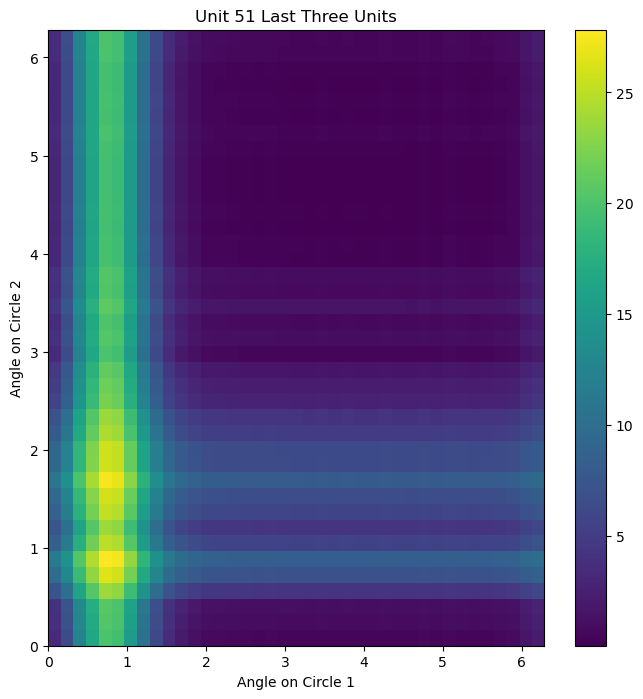

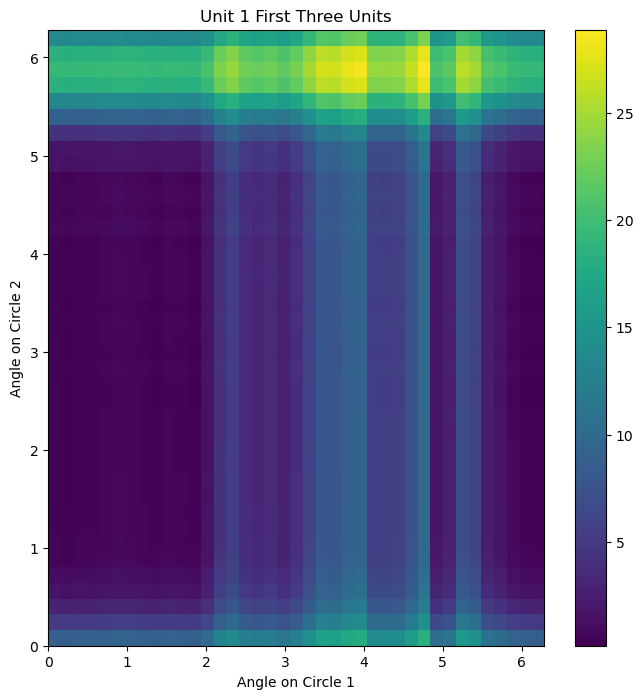

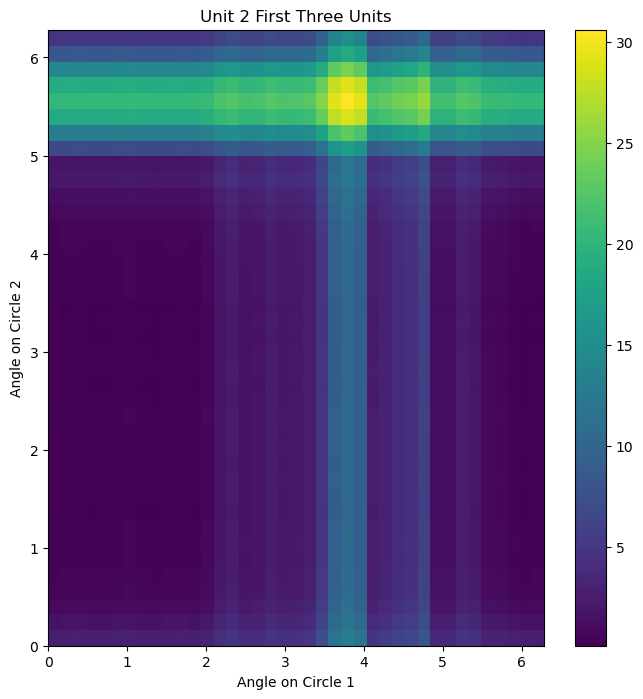

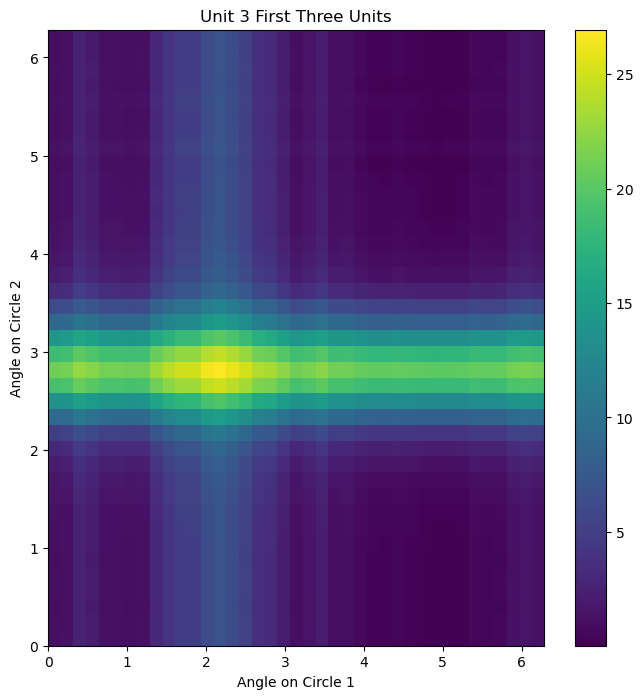

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

# Helper functions

def CircleDist(a, b):
    dx = abs(a - b)
    dx = np.minimum(dx, 2 * np.pi - dx)
    return dx

def gaussian_walk_on_circle(start, T, sigma):
    walk = np.zeros(T)
    walk[0] = start
    for i in range(1, T):
        increment = np.random.normal(0, sigma)  # Generate a Gaussian increment
        walk[i] = (walk[i - 1] + increment) % (2 * np.pi)  # Wrap around the circle
    return walk

def makehddata(N, T):
    h = 0.1
    beta0 = 20
    beta_and_h = (beta0 / h)
    sigma = np.pi / 4
    start1 = np.random.uniform(0, 2 * np.pi)
    start2 = np.random.uniform(0, 2 * np.pi)
    hd_sim = np.array([gaussian_walk_on_circle(start1, T, sigma/10),
                       gaussian_walk_on_circle(start2, T, sigma/10)])
    rf_hd1 = np.random.uniform(0, 2 * np.pi, size=(N))
    rf_hd2 = np.random.uniform(0, 2 * np.pi, size=(N))
    S = np.zeros((N, T))

    allocation = np.zeros(N)
    for i in range(N):
        for t in range(T):
            if i < N/2:
                dist1 = CircleDist(rf_hd1[i], hd_sim[0, t])
                response = np.log(h) + np.log(beta_and_h) * np.exp(-dist1**2 / (2 * sigma**2))
                allocation[i] = 0
                S[i, t] = np.random.poisson(lam=np.exp(response))
            else:
                dist2 = CircleDist(rf_hd2[i], hd_sim[1, t])
                response = np.log(h) + np.log(beta_and_h) * np.exp(-dist2**2 / (2 * sigma**2))
                allocation[i] = 1
                S[i, t] = np.random.poisson(lam=np.exp(response))

            # Zero out responses for the unallocated circle
            if allocation[i] == 0:
                S[i, t] *= (np.cos(hd_sim[0, t])**2 + np.sin(hd_sim[0, t])**2)
            else:
                S[i, t] *= (np.cos(hd_sim[1, t])**2 + np.sin(hd_sim[1, t])**2)
    
    rf_hd = (rf_hd1, rf_hd2)
    return hd_sim, S, rf_hd, allocation

# Generating data
np.random.seed(1001)
N = 100
T = 4000
hd_sim, S, rf_hd_array, allocation = makehddata(N, T)

# Splitting data into training and testing sets
split_index = int(T * 0.8)
hd_sim_train = hd_sim[:, :split_index]
hd_sim_test = hd_sim[:, split_index:]
S_train = S[:, :split_index]
S_test = S[:, split_index:]

# Saving data to a compressed pickle file
data = {'hd_train': hd_sim_train, 'hd_test': hd_sim_test, 'S_train': S_train, 'S_test': S_test}
with gzip.open('twocirclesseparable.pkl.gz', 'wb') as f:
    pickle.dump(data, f)

# Plotting
nr_bins = 40
angles = np.linspace(0, 2 * np.pi + 0.00001, nr_bins)
angleverts = (0.5 * (angles[:-1] + angles[1:]))
angleverts2d = np.zeros((nr_bins - 1, nr_bins - 1))

def plot_heatmaps(S, hd_sim, units, title):
    for i in units:
        angleverts2d = np.zeros((nr_bins - 1, nr_bins - 1))
        for j in range(len(angleverts)):
            inds0 = (hd_sim[0] >= angles[j]) & (hd_sim[0] < angles[j + 1])
            for k in range(len(angleverts)):
                inds1 = (hd_sim[1] >= angles[k]) & (hd_sim[1] < angles[k + 1])
                
                if np.any(inds0) and np.any(inds1):
                    angleverts2d[j, k] = np.mean(S[i, inds0]) + np.mean(S[i, inds1])

        plt.figure(figsize=(8, 8))
        plt.title(f'Unit {i+1} {title}')
        plt.imshow(angleverts2d, extent=(0, 2 * np.pi, 0, 2 * np.pi), origin='lower', aspect='auto')
        plt.colorbar()
        plt.xlabel('Angle on Circle 1')
        plt.ylabel('Angle on Circle 2')
        plt.show()

# Plotting the last three units
plot_heatmaps(S, hd_sim, range(int(N/2-1),int(N/2+1)), 'Last Three Units')

# Plotting the first three units
plot_heatmaps(S, hd_sim, range(3), 'First Three Units')


(100, 4000)
